# Retweet Data Analysis (vectorized by tf-idf)

In [1]:
import numpy as np
import pandas as pd

# Load Dataset
dataset = pd.read_csv("retweet_data.csv")[:610]    #去掉後幾列NA值(後9列為NA)

X = dataset['retweet_text'].tolist()

## Text preprocessing

首先進行資料的前處理，步驟包含去除網址、標點符號，並統一將文字轉為小寫字母，最後做Lemmatization(詞形還原)

In [4]:
import re
import nltk

nltk.download('wordnet')
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for num in range(len(X)):  
    # 去URL
    document = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', X[num])
    
    # 去標點
    document = re.sub(r'\W', ' ', document)

    # 去單一字母s
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # 轉小寫
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append([document])

## Feature Extracting

利用TF-IDF 建立feature

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

X_tfidf = vectorizer.fit_transform(X)

## Data Visualization

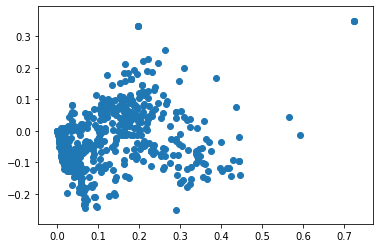

In [14]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_tfidf_reduce = svd.fit_transform(X_tfidf)

import matplotlib.pyplot as plt
plt.scatter(X_tfidf_reduce.T[0], X_tfidf_reduce.T[1], marker='o')
plt.show()

## Truncated SVD to do feature dimension reduction

In [15]:
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
X_tfidf_select = svd.fit_transform(X_tfidf)

## K-mean: Elbow Method

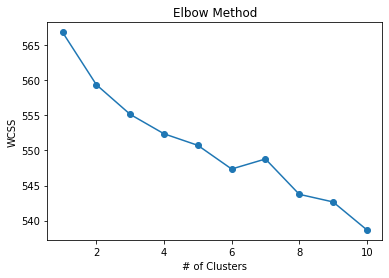

In [16]:
#K-Means Clustering
from sklearn.cluster import KMeans
import time

### Find Best K
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=int(time.time()))
    kmeans.fit(X_tfidf_select)
    wcss.append(kmeans.inertia_)
##
### Draw WCSS for each K
import matplotlib.pyplot as plt
##
plt.plot(range(1, 11), wcss,'o-')
plt.title("Elbow Method")
plt.xlabel("# of Clusters")
plt.ylabel("WCSS")
#plt.savefig("doc2vec_text8_elbow.png")
plt.show()

## K-means: Average Silhouette method:

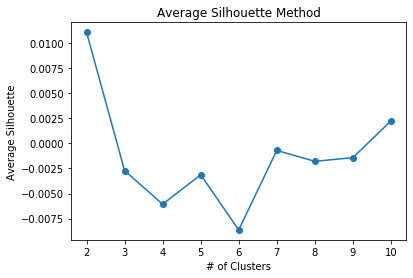

In [17]:
from sklearn.metrics import silhouette_score

silhouette = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=int(time.time()))
    kmeans.fit(X_tfidf_select)
    silhouette.append(silhouette_score(X_tfidf_select, kmeans.labels_))

plt.plot(range(2, 11), silhouette,'o-')
plt.title("Average Silhouette Method")
plt.xlabel("# of Clusters")
plt.ylabel("Average Silhouette")
plt.show()

## K-means

In [18]:
#Prediction
kmeans = KMeans(n_clusters=2, init="k-means++", random_state=int(time.time()))
Y_pred = kmeans.fit_predict(X_tfidf_select)

In [19]:
#add prediction results to dataset
dataset['pred'] = Y_pred
dataset.to_csv("retweet_prediction_tf-idf_selected features.csv")

## K-means result Visualization

In [20]:
df = pd.DataFrame(X_tfidf_reduce, columns=['PC1','PC2'])
df['pred'] = Y_pred
df

,PC1,PC2,pred
0,0.070553,-0.119187,1
1,0.064378,-0.127057,1
2,0.030626,-0.068035,1
3,0.022527,-0.044540,1
4,0.113388,0.053790,1
...,...,...,...
605,0.138687,-0.197822,1
606,0.140327,-0.203273,1
607,0.164325,0.075259,0
608,0.164325,0.075259,0


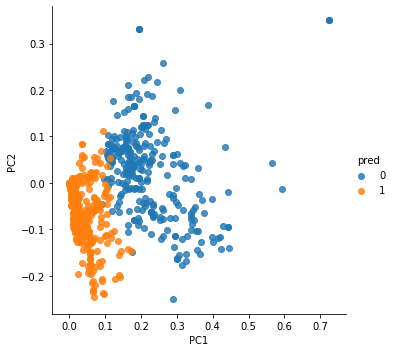

In [21]:
import seaborn as sns
facet = sns.lmplot(data=df, x='PC1', y='PC2', hue='pred', 
                   fit_reg=False, legend=True, legend_out=True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


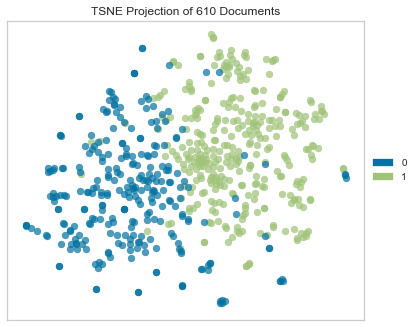

In [25]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(X_tfidf, Y_pred)
tsne.show()

## 註：輸出tf-idf vectorized後的sparse matrix

In [31]:
df1 = pd.DataFrame(X_tfidf.toarray(),
                  columns = ['feature_' + str(i) for i in range(X_tfidf.shape[1])])

import numpy as np
merge = pd.concat([dataset.iloc[:,:6],df1],axis=1)
merge.to_csv("15_retweet_text_tfidf.csv")